<a href="https://colab.research.google.com/github/mrcarlson3/Proj1Math/blob/main/3025_Project1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 - K-Means Clustering

Due Thursday Jan 30th at 11:59pm

**Chat GPT Policy:** This assignment will be worked on in groups of 3 (assigned randomly) and chat gpt can be used for "small code help" such as if you forget syntax or numpy function names, etc. but not for larger prortions (i.e. don't copy the questions into chat gpt)

-- **Alka Link, Michael Carlson, Emujin Batzorig** --

-- **On my honor as a student, I have neither given nor received unauthorized aid on this assignment.** -- (points will be deducted if not)

# Overview of K-Means Clustering

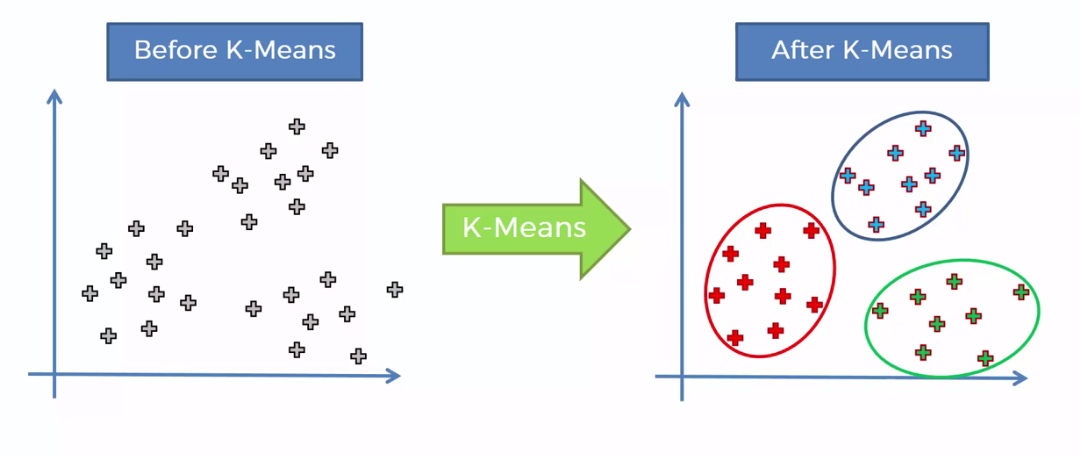

### The general steps in the K-means clustering algorithm are:
1. Choose the number of clusters: Decide on the value of \(k\), which is the number of clusters you want to create. K-means is an unsuperised learning method and in this example k is given.
2. Initialize centroids: Assign each data point randomly to a cluster, then compute each centroid (mean of cluster)
3. Calculate distances: For each data point, calculate the distance between it and each centroid.
4. Assign data points to clusters: Assign each data point to the cluster with the closest centroid.
5. Recalculate centroids: Find the new location of each centroid by calculating the mean of all the data points in its cluster.
6. Repeat: Repeat steps 3–5 until the centroids stop changing.      

### Further Explaination:
The K-means clustering algorithm is an iterative process that continues until the model stops improving. The algorithm outputs the final cluster centroids and the assignment of each data point to a cluster once convergence is achieved.            To determine the optimal number of clusters, you can use the elbow method. This method plots the mean distance between data points and centroids against a range of \(k\) values. The "elbow point" is where the rate of decrease in distance shifts, and this point usually represents the ideal \(k\).

## Cost function (Sum of Squared Distances)

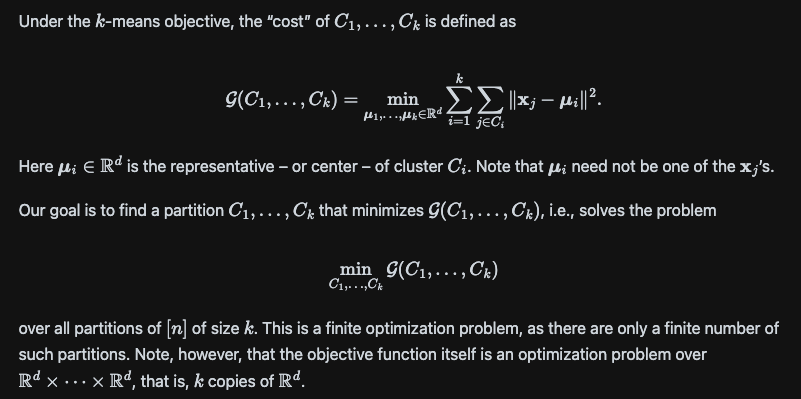

In [7]:
# Install packages
!pip install ucimlrepo

In [8]:
# Load packages
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns

# Data and Exploratory Data Analyis (EDA)

**Goal:** Cluster The Presence of Heart Dissease in Patients

Source: https://archive.ics.uci.edu/dataset/45/heart+disease

Labels: 0 (no presence) to 4

**Clusters:** k = 5

In [9]:
# Fetch Dataset
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas dataframes - split into data and labels)
X = heart_disease.data.features
y = heart_disease.data.targets

# Metadata
print(heart_disease.metadata)

# Variable Information
#print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [10]:
# View Snapshot of Data
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


### 1. Are there any missing data? Check for nan values. If there are any missing data, remove them.

In [11]:
# Check for missing data
X.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [12]:
# Remove missing data
X = X.dropna()

### 1.5 Remove Binary Columns

In [13]:
# Keep only continuous columns
X = X[['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach',
       'oldpeak', 'slope', 'ca', 'thal']]
X.head()

,age,cp,trestbps,chol,restecg,thalach,oldpeak,slope,ca,thal
0,63,1,145,233,2,150,2.3,3,0.0,6.0
1,67,4,160,286,2,108,1.5,2,3.0,3.0
2,67,4,120,229,2,129,2.6,2,2.0,7.0
3,37,3,130,250,0,187,3.5,3,0.0,3.0
4,41,2,130,204,2,172,1.4,1,0.0,3.0


### 2. Turn data into a numpy array


In [14]:
# Turn data into a numpy array
Xarray = np.array(X)
Xarray

array([[ 63.,   1., 145., ...,   3.,   0.,   6.],
       [ 67.,   4., 160., ...,   2.,   3.,   3.],
       [ 67.,   4., 120., ...,   2.,   2.,   7.],
       ...,
       [ 68.,   4., 144., ...,   2.,   2.,   7.],
       [ 57.,   4., 130., ...,   2.,   1.,   7.],
       [ 57.,   2., 130., ...,   2.,   1.,   3.]])

### 3. How many patients are included in the dataset? (assume each line is a unique patient)

In [15]:
# How many patients are included in the dataset? (assume each line is a unique patient)
Xarray.shape[0]

297

### 4. What dimension is our dataset in? (how many columns are there)

In [16]:
# What dimension is our dataset in? (how many columns are there)
Xarray.shape[1]


10

### 5. How many unique label categories are there and what are they? (show with code)

In [18]:
# How many unique label categories are there and what are they? (show with code)
labels = X.columns.tolist()
print(X.shape[1])
print(labels)


10
['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'thal']


### 6. In *k*-Means clustering, what does *k* represent? Is this a supervised or unsupervised classification method?

In [ ]:
# What is k? Will this be a supervised or unsupervised method?

# k represents the number of clusters that the data set will be divided into.
# This is an unsupervised classification method because it does not rely on
# labeled data to find patterns, but groups data together solely on their similarities.

### 7. Should we standardize the data? If so, explain why and standardize the data. If not, explain why not.(Hint: To standardize, you must first calculate the mean and standard deviation of each column)

In [20]:
# Standardize the data and explain which method you chose and why this needs to be done (hint - compute the mean and standared deviation first)

# Standardizing is an important step in k means clustering because it normalizes the range of each feature so that no single feature dominates when calculating Euclidean distances.

In [19]:
mean = np.mean(Xarray, axis=0)   # Compute mean for each column
std = np.std(Xarray, axis=0) # Compute standard deviation for each column
Xarray = (Xarray - mean) / std # Standardize each column
print(mean,std)

[ 54.54208754   3.15824916 131.69360269 247.35016835   0.996633
 149.5993266    1.05555556   1.6026936    0.67676768   4.73063973] [ 9.03448759  0.9632337  17.73287744 51.90997071  0.99323746 22.90290734
  1.16415796  0.61714517  0.93738245  1.9353622 ]


# Starter Code (Lloyd's Algorithm)

You will be using the code provided that we discussed in class as a start for this project. Please annotate the code in a way that shows you understand the purpose of each line/piece of the code and relate it to equations/math we learned in class. **<- This is very important.** An example annotation is shown below for a function that calcluates the l2 norm of two vectors (this code is for example only, you will not need it for the project).

In [21]:
def l2_norm(v1, v2):
    """
    Calculates the L2 norm (Euclidean distance) between two vectors.

    Parameters:
        v1 (list or numpy.ndarray): The first vector.
        v2 (list or numpy.ndarray): The second vector.

    Returns:
        float: The L2 norm of the two vectors.
    """

    # Convert vectors to numpy arrays if they aren't already
    v1 = np.array(v1)
    v2 = np.array(v2)

    # Check if vectors have the same length
    if len(v1) != len(v2):
        raise ValueError("Vectors must have the same length.")

    # Calculate the element-wise squared difference
    diff_squared = (v1 - v2) ** 2

    # Sum the squared differences
    sum_of_squares = np.sum(diff_squared)

    # Return the square root of the sum
    return np.sqrt(sum_of_squares)

In [29]:
def opt_reps(X, k, assign):
   """
   Calculates the best representatives for each cluster given current data points
   Parameters:
       X (numpy.ndarray): The data points.
       k (int): The number of clusters.
       assign (numpy.ndarray): The cluster assignments for each data point.
   Returns:
       numpy.ndarray: The best representatives for each cluster.
   """
   # Get the shape of the data and set to (n,d)
   (n, d) = X.shape
   # Creates array with zeros of the shape (k,d)
   reps = np.zeros((k, d))
   """ for each cluster, take the data points assigned to each cluster,
    finds the sum of all data points and divides it by the number of points to find the new centroid
    and then updates the reps array with the new centroid
    """
   for i in range(k):
       in_i = [j for j in range(n) if assign[j] == i]
       reps[i,:] = np.sum(X[in_i,:],axis=0) / len(in_i)
   # return the updates reps array with new centroids for each cluster
   return reps


In [31]:
def opt_clust(X, k, reps): # assigning data points into best clusters and computing the sum of squared distance
# it takes 3 parameters:
#    1. X representing the dataset, each row is a dataset
#    2. k is the number of clusters
#    3. reps is where we define the center of the clusters to be
# it returns an array consisting of data points and index for its best cluster

# Get n (number of data points) and d (features)
   (n, d) = X.shape

# Initialize arrays to store distances and cluster assignments
   dist = np.zeros(n) # storing the distance of each point to its assigned cluster
   assign = np.zeros(n, dtype=int) # stores the index of the cluster to corresponding data points
  # for loop, iterating over each data point, repeating the same task
   for j in range(n):
     # Compute the Euclidean distance between the data point and each cluster reps
       dist_to_i = np.array([LA.norm(X[j,:] - reps[i,:]) for i in range(k)])
     # Assign the data point to the nearest clusters, meaning clusters with the smallest distance
       assign[j] = np.argmin(dist_to_i)
     # Storing the distance
       dist[j] = dist_to_i[assign[j]]

   # Compute the sum of squared distance
   G = np.sum(dist ** 2) # sum of squared distances - similar to inertia

   # Print the computational result
   print(G)
   return assign

In [32]:
def kmeans(rng, X, k, maxiter=5): # taking parameters, a random number generator, X (the dataset), k (the number of clusters), and maxiter (max number of iterations (5))
  (n, d) = X.shape # gets number of data points (n) and number of features (d)
  assign = rng.integers(0,k,n) # randomly assigns each data point to a k cluster
  reps = np.zeros((k, d), dtype=int) # stores cluster centroids in algorithm
  for iter in range(maxiter): # performs most maxiter iterations (5)
      reps = opt_reps(X, k, assign) # creates new cluster centroids based on current cluster assignments
      assign = opt_clust(X, k, reps) # reassigns each data point to the closet centroid
  return assign # returns final cluster assignments


# Your Turn

### 8. Use the kmeans and opt_reps functions to obtain the centers of each of the 5 clusters.

In [44]:
# hint: you need to create a random number generator as an input to kmeans (rng)
# define a seed and random number generator for the implementation input
seed = 123
rng = np.random.default_rng(seed)

# Use the kmeans and opt_reps functions to obtain the centers of each of the 5 clusters
k = kmeans(rng, Xarray, 5)
o = opt_reps(Xarray, 5, k)
print(o)


2675.2527313483515
2072.5547546767757
2005.425108282781
1991.9220833848603
1986.7417793071547
[[-0.81562503 -0.41345019 -0.42183055 -0.21300022 -0.62754345  0.73006772
  -0.59632992 -0.69572005 -0.50861596 -0.89422007]
 [ 0.65443201  0.18176708  0.11126587 -0.00557816 -0.33221293  0.33107114
  -0.31062465 -0.58376761  1.31464296  0.51495942]
 [ 0.38274583 -0.33975477  0.19598688  0.26457997  0.79749247  0.08575565
  -0.36954044  0.05040826 -0.40644353 -0.65406413]
 [ 0.58895716  0.64633615  0.37958052  0.20146517  0.2792279  -1.01306205
   1.11720993  0.82135527  0.7247807   0.74789228]
 [-0.67984902  0.04334446 -0.30353176 -0.38517866 -0.42170703  0.04854338
  -0.00763547  0.17567586 -0.65085602  0.93145025]]


### 9. Explain the output you received. What are the dimensions of the output and why? What do the values represent? Include your answer using markdown in this text cell.

> The output gives us two things. First it gives us a series of values that represent the center of each cluster as they are the squared distance from the center of the cluster, as calculated by the k means and integrated over several times. The second item is an array of the centroids of the cluster. Each centroid is a vector that represents the mean position of the data points for each cluster. This is broken up by each cluster being a row in the array. The dimensions of the output are 5x10, as there are 5 clusters and 10 features in the data set.

#### kmeans - our data is 1D array of 5 values. Each of the 5 numbers represents the sum of squared distances at each iteration of "kmeans". It ran for 5 iterations.  The values are decreasing, indicating a better clustering.


#### opt_reps - the output for this is (5, 10) array. 5 rows representing 5 clusters (we set the k=5) and 10 columns representing 10 features/columns of our data. Each values within the 5 rows represents the average value of features of all data points assigned in each cluster.


### 10. Plot your clusters in 2D. Color the points according to what cluster they are assigned to. You can use any two columns for the x and y axes of the plots.

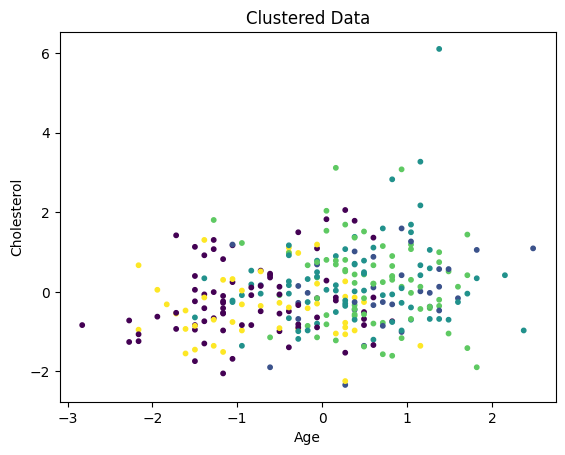

In [56]:
# Plot your clusters (color coded) in 2D (Can choose any two columns)

plt.scatter(Xarray[:,0], Xarray[:,3], s=10, c=k)
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Clustered Data')
plt.show()


### 11. Select 4 variables from the data set. Create a plot that shows all of your selected variables on the x-axis and the y-axis. Color the points according to the assigned cluster. (Hint: Review the final plot Section 1.1 of the Mathematical Methods in Data Science textbook)

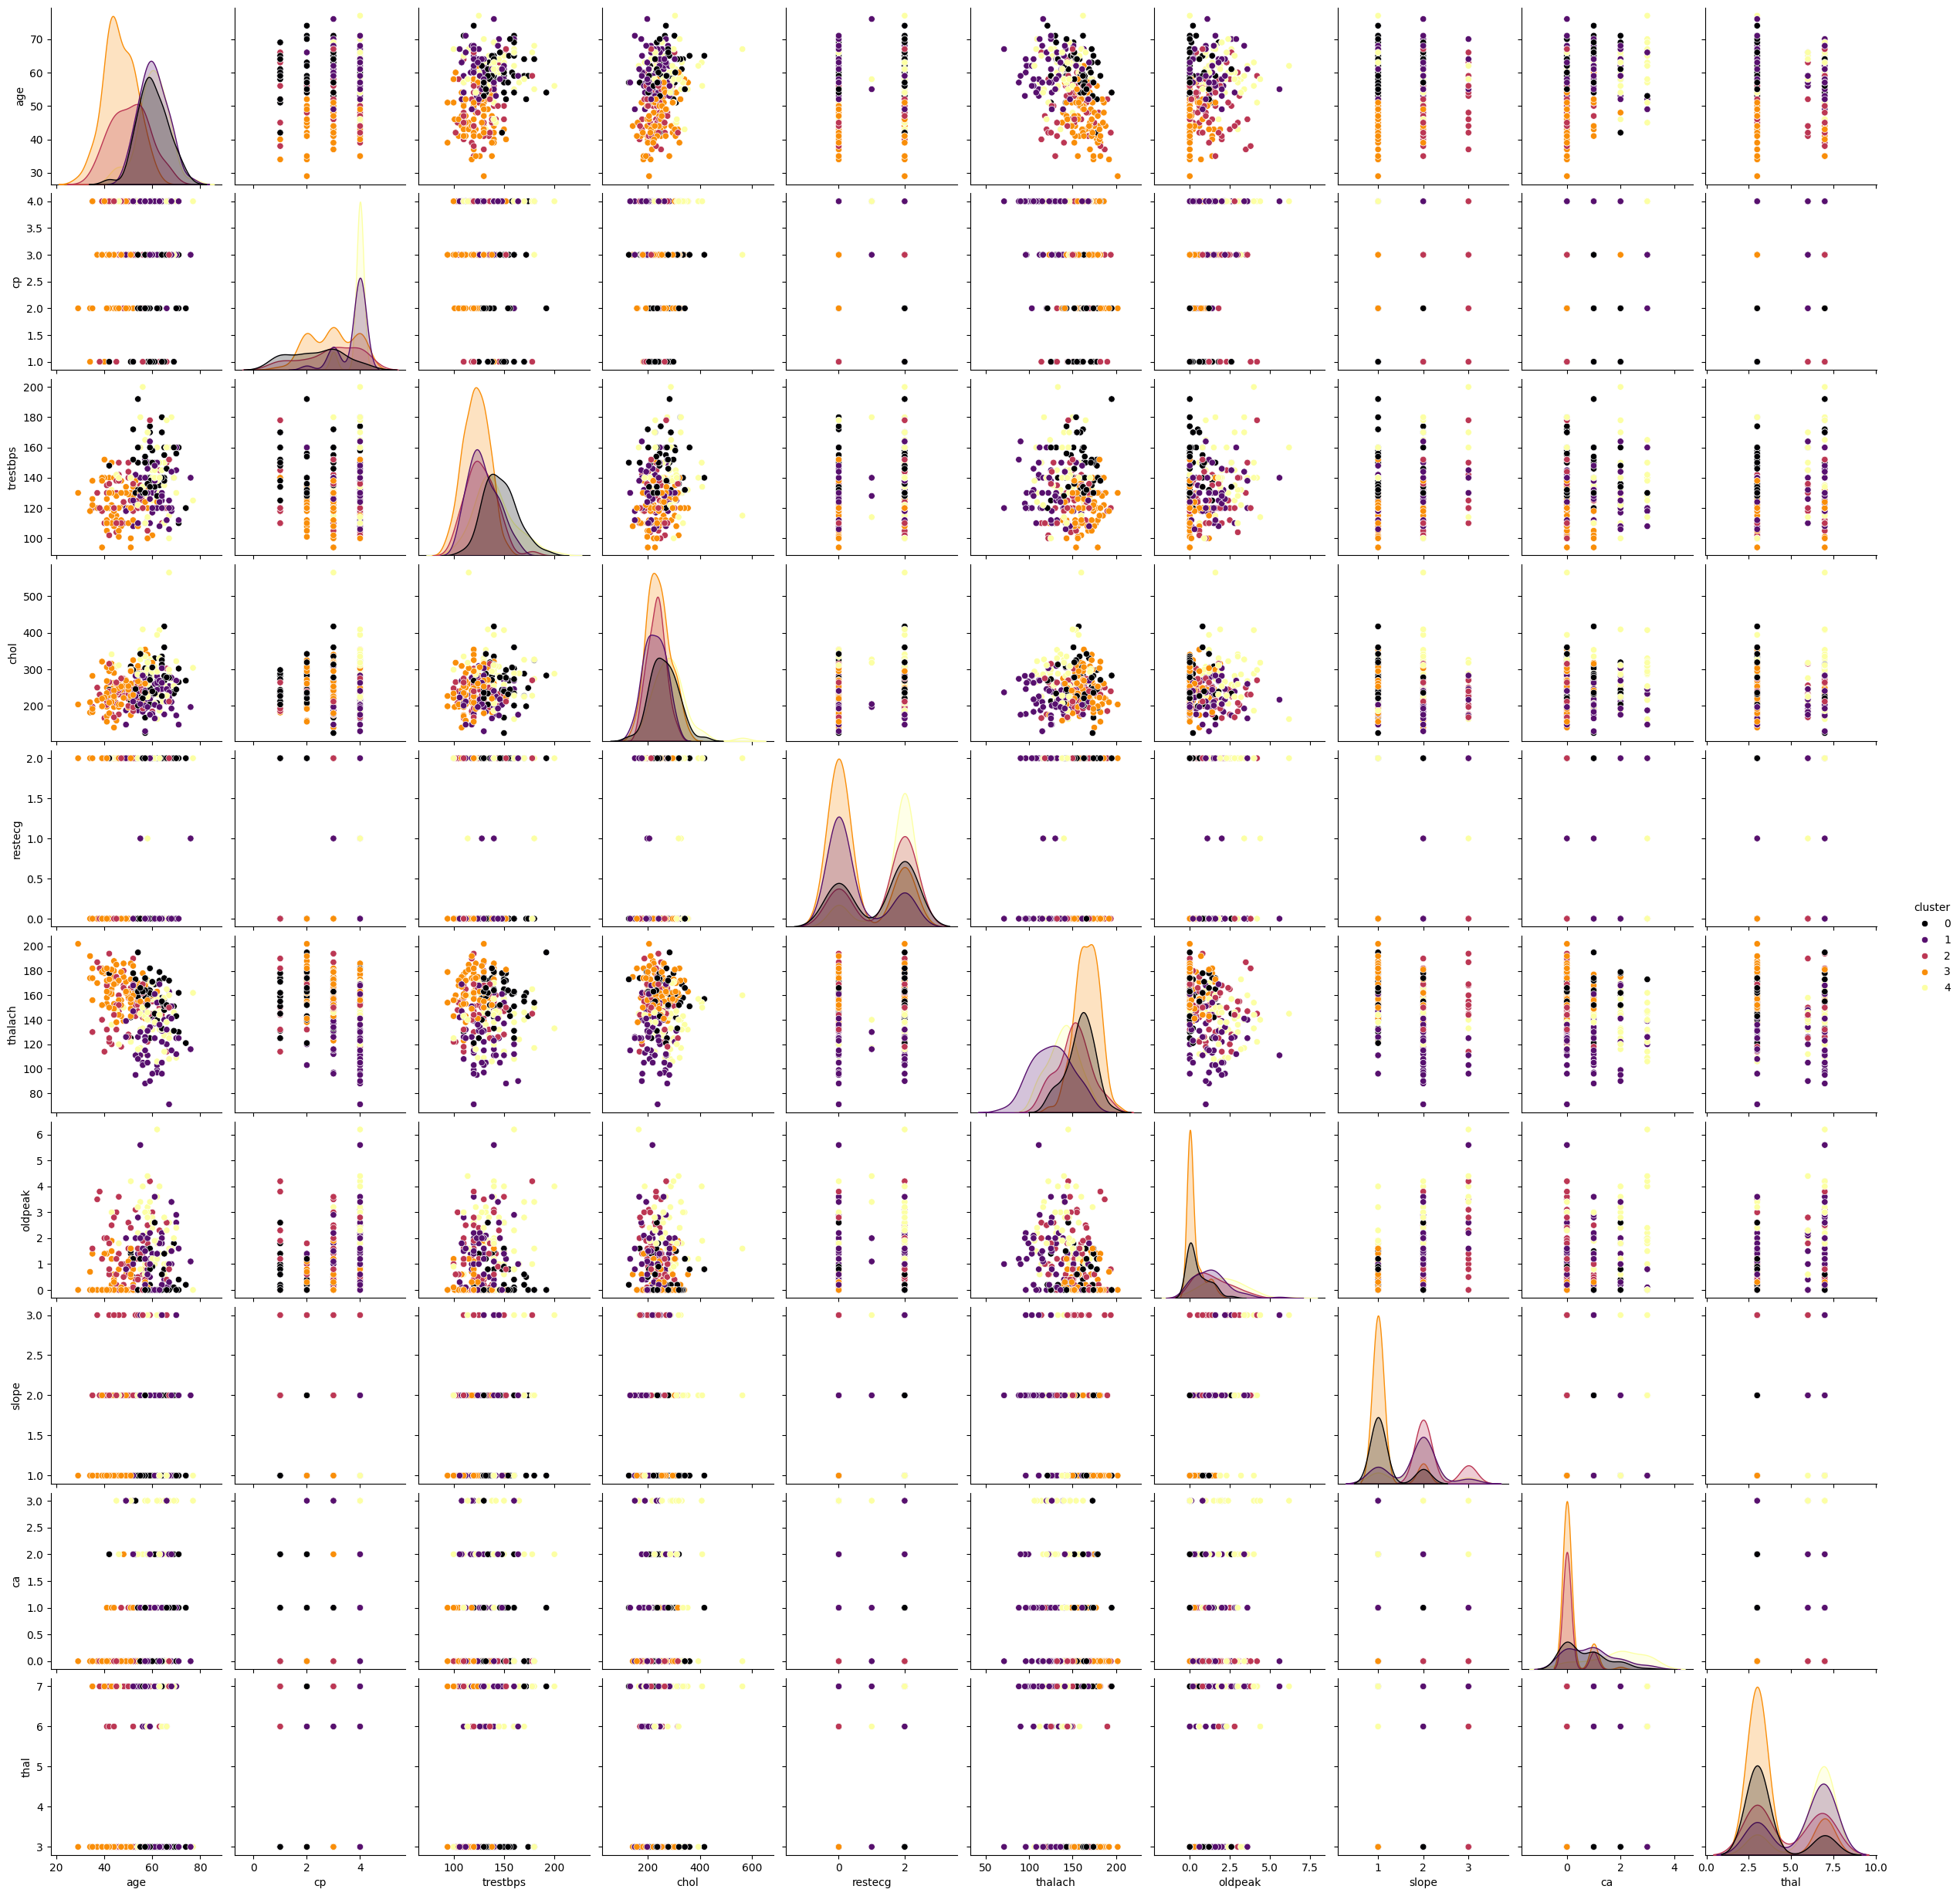

In [55]:
# Plot all possible combinations of your clusters (color coded)

X['cluster'] = assign
sns.pairplot(X, hue='cluster', palette='inferno')
plt.show()

### 12. Experiment with your choice of k (ex. try k = 2). What do you notice and how does it tie into our data (presence of heart disease)?

2898.0001393011717
2646.167221063394
2489.714771091157
2427.9609741375325
2412.763943898236


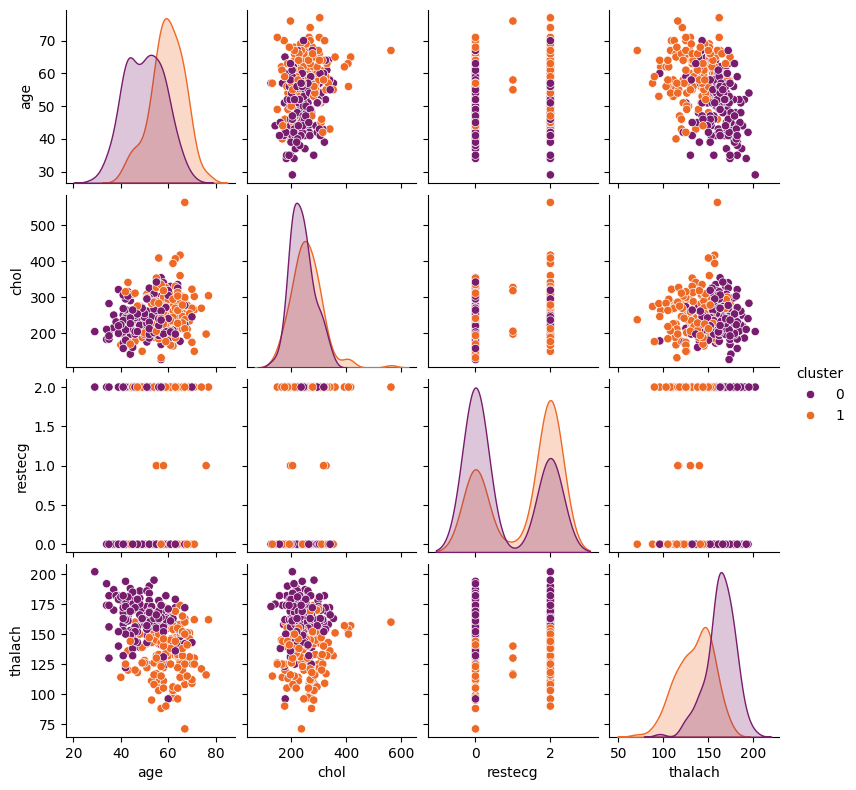

In [57]:
# Experiment with your choice of k (try k = 2). What do you notice and how does it tie into our data (presence of heart disease)?
kmean = kmeans(rng, Xarray, 2, maxiter=5)
X['cluster'] = kmean
sns.pairplot(X, hue='cluster', palette='inferno', height=2, vars=['age', 'chol', 'restecg', 'thalach'])


### 13.  An elbow plot is a tool to subjectively identify the best choise of *k* using the *k*-means Clustering cost function. Reference Lab2 for additional details on what an elbow plot is and looks like. Create an Elbow Plot and choose the best value of *k* for our data set. You will need to adjust the code given so that the function(s) return the sum of squared distances along with the cluster assignments (aka the variable "assign"). This will allow you to plot the *k* on the x-axis and the sum of squared distances on the y-axis as you iterate through each value of *k*. Test $1 \leq $ *k* $\leq 10$.

2970.0
2970.0
2970.0
2970.0
2970.0
2906.2605463928003
2724.858673302645
2633.127596415924
2488.0763711387667
2428.8532133377635
2824.641935061375
2426.9628634921073
2297.388095788437
2254.662425952781
2243.8596134469312
2706.7244008618163
2150.9941010010407
2101.026688091844
2090.4131016160145
2088.4676083199765
2679.485375759938
2122.1371780721965
2037.95856234034
1995.0415975693595
1977.6294224193884
2675.1001003381743
2052.2144880238193
1960.7054568883243
1916.5939592276327
1889.909598193616
2639.061335095612
1933.6536034944065
1863.4980122733991
1832.4311052841651
1817.693954582263
2494.245842516376
1897.3119458815975
1824.1923114400088
1777.9510012031596
1748.2663106117652
2500.921496404734
1818.3065031042727
1742.1883492757593
1705.0950178078183
1687.4721437567396


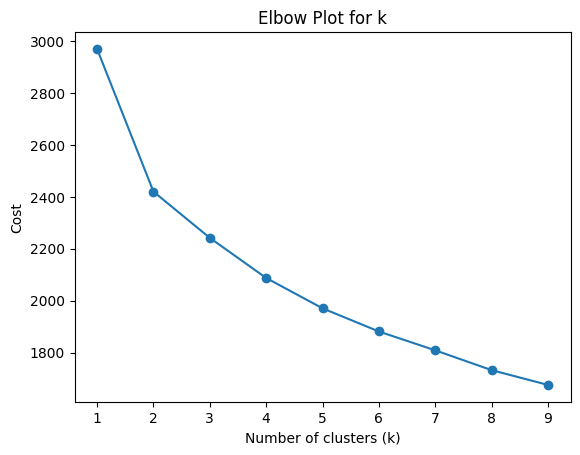

In [58]:
# Create an Elbow Plot (k on the x axis and cost function on the y axis) and choose the best value of k
# You will need to adjust the code given so that the function(s) return the sum of squared distances along with the cluster assignments (aka the variable "assign")
# This will allow you to plot the k on the x axis and the sum of squared distances on the y axis as you iterate through each value of k
# Test k=1 though k = 10 (inclusive)

k_values = np.arange(1, 10)
costs = []
for k in k_values:
   assign = kmeans(rng, Xarray, k, maxiter=5)
   reps = opt_reps(Xarray, k, assign)
   cost = np.sum((Xarray - reps[assign]) ** 2)
   costs.append(cost)


plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Plot for k')
plt.plot(k_values, costs, marker='o')



### 14.  The starter code does not output a cost function that penalizes for larger values of *k*. Why is that an issue? If *k* was equal to our number of data points would that tell us anything? How could we adjust the code to ensure our optimal *k* value is not too large?

In [ ]:
""" Too large k value is an issue known as overfitting.
For example, if k was equal to our number of data points, we would have
each data points as its own cluster. This is an issue because the model learns
too closely from the training data. There is no analysis to be made in that case.
To prevent this overfitting issue, we use the elbow method where examine the trend of the SSD
as k increases. After a certain point, it slows down with diminishing returns.
The elbow point is where the SSD curve starts to flatten, and this is the optimal value for k. """
